---
title: "Transformer Validation Pipeline"
description: "Complete validation pipeline for transformer models using PyTorch's nn.Transformer"
date: "2025-08-01"
bread-crumbs: true
back-to-top-navigation: true
toc: true
toc-depth: 3
---

This section implements a complete English-French translator using PyTorch's built-in `nn.Transformer` class.

## Setup and Imports

First, let's set up our environment. 
We're using PyTorch's built-in transformer (no need to reinvent the wheel), plus some essential libraries for data handling and visualization.

We set random seeds for reproducibility.

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

import math
import random
import numpy as np
from collections import Counter
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch version: 1.13.1
CUDA available: False
Using device: cpu


## Preparing Dataset

Always start with your data. 
Let's load our English-French translation pairs and understand what we're working with.

In [ ]:
# Download data
import os
import pandas as pd

# Set environment flag - change this to True when running in Colab
COLAB = False

if COLAB:
    # Original Colab code using Kaggle Hub
    import kagglehub
    from kagglehub import KaggleDatasetAdapter

    # Set the path to the file you'd like to load
    file_path = "eng_-french.csv"

    # Load the latest version
    df = kagglehub.load_dataset(
      KaggleDatasetAdapter.PANDAS,
      "devicharith/language-translation-englishfrench",
      file_path,
      # Provide any additional arguments like
      # sql_query or pandas_kwargs. See the
      # documenation for more information:
      # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
    )

    # Shuffle the dataframe with a fixed seed
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    df = df[:1000]
    
else:
    # Local file loading
    csv_file_path = "english_french_translations.csv"
    
    if os.path.exists(csv_file_path):
        df = pd.read_csv(csv_file_path)
    else:
        raise FileNotFoundError(f"CSV file '{csv_file_path}' not found")

display(df.head())

Loading data from local file: english_french_translations.csv
Loaded 1000 translation pairs from CSV file


,English words/sentences,French words/sentences
0,Take a seat.,Prends place !
1,I wish Tom was here.,J'aimerais que Tom soit là.
2,How did the audition go?,Comment s'est passée l'audition ?
3,I've no friend to talk to about my problems.,Je n'ai pas d'ami avec lequel je puisse m'entr...
4,I really like this skirt. Can I try it on?,"J'aime beaucoup cette jupe, puis-je l'essayer ?"


Now let's prepare our translation pairs and split them into training and validation sets. The 80/20 split is a classic ratio that gives enough training data while preserving examples for unbiased evaluation.

In [14]:
# Use the downloaded data from the dataframe 'df'
# Assuming 'df' has columns named 'English words/sentences' and 'French words/sentences'
translation_pairs = []
for index, row in df.iterrows():
    english_sentence = row['English words/sentences']
    french_sentence = row['French words/sentences']
    translation_pairs.append((english_sentence, french_sentence))

# Split into training and validation sets
train_size = int(0.8 * len(translation_pairs))
train_pairs = translation_pairs[:train_size]
val_pairs = translation_pairs[train_size:]

print(f"Total pairs: {len(translation_pairs)}")
print(f"Training pairs: {len(train_pairs)}")
print(f"Validation pairs: {len(val_pairs)}")
print(f"\\nExample pairs:")
for i, (en, fr) in enumerate(train_pairs[:3]):
    print(f"{i+1}. English: '{en}' -> French: '{fr}'")

Total pairs: 1000
Training pairs: 800
Validation pairs: 200
\nExample pairs:
1. English: 'Take a seat.' -> French: 'Prends place !'
2. English: 'I wish Tom was here.' -> French: 'J'aimerais que Tom soit là.'
3. English: 'How did the audition go?' -> French: 'Comment s'est passée l'audition ?'


## Data Preprocessing and Tokenization

Since computers don't understand words,our job is to convert text into integers that the transformer can process.

Think of vocabulary as a bilingual dictionary where every unique word gets a number:
- "hello" → 42
- "bonjour" → 17
- "world" → 1337

**Critical special tokens** (these aren't arbitrary - they're mathematically necessary):
- `<pad>` (0): Padding token - makes all sequences the same length
- `<sos>` (1): Start of sequence - tells the decoder "begin translation"
- `<eos>` (2): End of sequence - tells the decoder "stop generating"  
- `<unk>` (3): Unknown token - handles words not seen during training

The Data Flow Pipeline:
```
Raw text → Tokenization → Vocabulary lookup → Integer sequences → Tensor batches
```

We use 80/20 split - a classic ratio that gives enough training data while preserving examples for unbiased evaluation.

In [ ]:
class Vocabulary:
    def __init__(self):
        self.word2idx = {"<pad>": 0, "<sos>": 1, "<eos>": 2, "<unk>": 3}
        self.idx2word = {0: "<pad>", 1: "<sos>", 2: "<eos>", 3: "<unk>"}
        self.word_count = {}
        self.n_words = 4  # Count default tokens

    def add_sentence(self, sentence):
        # Simple split by space for now - can be improved with a proper tokenizer
        for word in sentence.lower().split():
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.n_words
            self.idx2word[self.n_words] = word
            self.word_count[word] = 1
            self.n_words += 1
        else:
            self.word_count[word] += 1

    def sentence_to_indices(self, sentence, add_eos=True):
        indices = [self.word2idx["<sos>"]]
        for word in sentence.lower().split():
            if word in self.word2idx:
                indices.append(self.word2idx[word])
            else:
                indices.append(self.word2idx["<unk>"])
        if add_eos:
            indices.append(self.word2idx["<eos>"])
        return indices

    def indices_to_sentence(self, indices):
        words = []
        for idx in indices:
            if idx == self.word2idx["<eos>"]:
                break
            if idx not in [self.word2idx["<pad>"], self.word2idx["<sos>"]]:
                words.append(self.idx2word[idx])
        return " ".join(words)

# Create vocabularies
english_vocab = Vocabulary()
french_vocab = Vocabulary()

# Build vocabularies from training data
for en_sentence, fr_sentence in train_pairs: 
    english_vocab.add_sentence(en_sentence)
    french_vocab.add_sentence(fr_sentence)

print(f"English vocabulary size: {english_vocab.n_words}")
print(f"French vocabulary size: {french_vocab.n_words}") 



Building vocabularies...
English vocabulary size: 1481
French vocabulary size: 1790
\nEnglish words: ['<pad>', '<sos>', '<eos>', '<unk>', 'take', 'a', 'seat.', 'i', 'wish', 'tom']
French words: ['<pad>', '<sos>', '<eos>', '<unk>', 'prends', 'place', '!', "j'aimerais", 'que', 'tom']
\nTokenization test (using training vocabulary words):
'I wish Tom' -> [1, 7, 8, 9, 2]
'Je prends place' -> [1, 17, 4, 5, 2]
Back to text: 'i wish tom'
Back to text: 'je prends place'
\n📝 Note: Previously 'Hello world' became <unk> <unk> because
those words don't exist in our training data. The vocabulary only
contains words seen during training from the 1000 translation pairs.


**Source texts**: The input language (English sentences we want to translate)
**Target texts**: The output language (French sentences we want to generate)

Example:
```
Source: "I wish Tom was here."     → [1, 8, 9, 10, 11, 2]  (English tokens)
Target: "J'aimerais que Tom soit là." → [1, 7, 8, 9, 10, 11, 2]  (French tokens)
```

Both get converted to integer sequences using their respective vocabularies.


In [ ]:
# Test tokenization using actual words from our training vocabulary
test_en = "I wish Tom was here."  
test_fr = "J'aimerais que Tom soit là."  
en_indices = english_vocab.sentence_to_indices(test_en)
fr_indices = french_vocab.sentence_to_indices(test_fr) 

print(f"'{test_en}' -> {en_indices}")
print(f"'{test_fr}' -> {fr_indices}") 
print(f"Back to text: '{english_vocab.indices_to_sentence(en_indices)}'")
print(f"Back to text: '{french_vocab.indices_to_sentence(fr_indices)}'")

## Creating PyTorch Datasets

Now we need to package our data into PyTorch's `Dataset` and `DataLoader` classes. This handles the conversion from text to tensors and ensures efficient batching during training.


### Padding: Making Batches Uniform

**The problem**: Neural networks need tensors of consistent size, but sentences have different lengths:
- "Take a seat." → 4 tokens
- "I've no friend to talk to about my problems." → 10 tokens

**The solution**: Pad shorter sequences with `<pad>` tokens (index 0) to match the longest sequence in each batch:

```
Batch before padding:
[1, 4, 5, 6, 2]           # "take a seat." (5 tokens)
[1, 8, 9, 10, 11, 12, 13, 14, 15, 16, 2]  # longer sentence (11 tokens)

Batch after padding:
[1, 4, 5, 6, 2, 0, 0, 0, 0, 0, 0]         # padded to 11 tokens
[1, 8, 9, 10, 11, 12, 13, 14, 15, 16, 2]  # already 11 tokens
```

The `collate_fn` takes a batch of these objects and creates padded tensors for efficient GPU processing.

In [ ]:
class TranslationDataset(Dataset):
    def __init__(self, pairs, src_vocab, tgt_vocab):
        self.pairs = pairs
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        src_sentence, tgt_sentence = self.pairs[idx]

        # Convert to indices
        src_indices = self.src_vocab.sentence_to_indices(src_sentence)
        tgt_indices = self.tgt_vocab.sentence_to_indices(tgt_sentence)

        return {
            'src': torch.tensor(src_indices, dtype=torch.long),
            'tgt': torch.tensor(tgt_indices, dtype=torch.long),
            'src_text': src_sentence,
            'tgt_text': tgt_sentence
        }

def collate_fn(batch):
    """Custom collate function to pad sequences in a batch"""
    src_sequences = [item['src'] for item in batch]
    tgt_sequences = [item['tgt'] for item in batch]
    src_texts = [item['src_text'] for item in batch]
    tgt_texts = [item['tgt_text'] for item in batch]

    # Pad sequences
    src_padded = pad_sequence(src_sequences, batch_first=True, padding_value=0)
    tgt_padded = pad_sequence(tgt_sequences, batch_first=True, padding_value=0)

    return {
        'src': src_padded,
        'tgt': tgt_padded,
        'src_text': src_texts,
        'tgt_text': tgt_texts
    }

# Create datasets
train_dataset = TranslationDataset(train_pairs, english_vocab, french_vocab)
val_dataset = TranslationDataset(val_pairs, english_vocab, french_vocab)

# Create data loaders
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Training batches: 200
Validation batches: 50
\nTesting data loader:
Source batch shape: torch.Size([4, 11])
Target batch shape: torch.Size([4, 11])
Source texts: ["Don't commit yourself.", 'With a little more effort, he would have succeeded.', 'Most Japanese houses are built of wood.', "You're very generous."]
Target texts: ["Ne t'engage pas.", "En faisant un peu plus d'effort, il aurait réussi.", 'La plupart des maisons japonaises sont faites en bois.', 'Tu es fort généreux.']


In [28]:
# Get a sample from the dataset
for batch in train_loader:
    print(f"Source batch shape: {batch['src'].shape}")
    print(f"Target batch shape: {batch['tgt'].shape}")
    print(f"Source indices: {batch['src']}")
    print(f"Target indices: {batch['tgt']}")
    print(f"Source texts: {batch['src_text']}")
    print(f"Target texts: {batch['tgt_text']}")
    break


Source batch shape: torch.Size([4, 13])
Target batch shape: torch.Size([4, 16])
Source indices: tensor([[   1,   39,  619,  266,  273, 1475, 1476,  298,   39,  409,   14,  312,
            2],
        [   1,    7,  218,  794,   52,  163,  867,    2,    0,    0,    0,    0,
            0],
        [   1,   86,    5,  246,  184,   14,  247,    2,    0,    0,    0,    0,
            0],
        [   1,  522,   14,  629,    2,    0,    0,    0,    0,    0,    0,    0,
            0]])
Target indices: tensor([[   1,  117, 1195,  359,  162,  298,   56,  323, 1783,  187,  125, 1784,
           69,   70,  689,    2],
        [   1,   17,  441,   19,  187,  908,    8,  196, 1016,   25, 1017,    2,
            0,    0,    0,    0],
        [   1,  117,  247,  167,  270,  175,  271,    2,    0,    0,    0,    0,
            0,    0,    0,    0],
        [   1,  574,   73,  700,    2,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0]])
Source texts: ['You must have women th

## Transformer Model



In [17]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_len=5000, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

        # Create positional encoding matrix
        pe = torch.zeros(max_seq_len, d_model)
        position = torch.arange(0, max_seq_len).unsqueeze(1).float()

        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                           -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len]
        return self.dropout(x)

### Building the Complete Transformer Model

**Why separate embeddings?** PyTorch's `nn.Transformer` is just the core attention mechanism - it expects continuous vectors as input, not discrete tokens. We need embeddings to convert our token indices (like 42 for "hello") into dense 256-dimensional vectors that can participate in attention.

- **Source vs Target Embeddings**: English and French have different vocabularies (1481 vs 1790 words), so they need separate embedding matrices. The English embedding learns that token 42 might represent "hello", while the French embedding learns that token 17 represents "bonjour".

- **Causal mask**: Prevents the decoder from "cheating" by looking at future tokens during training

In [ ]:

class TransformerModel(nn.Module):
    def __init__(self, 
                 src_vocab_size, 
                 tgt_vocab_size, 
                 d_model=256, 
                 nhead=8,
                 num_encoder_layers=3, 
                 num_decoder_layers=3, 
                 dim_feedforward=512,
                 dropout=0.1, 
                 max_seq_len=100):
        super().__init__()

        self.d_model = d_model
        self.src_vocab_size = src_vocab_size
        self.tgt_vocab_size = tgt_vocab_size

        # Embeddings
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)

        # Positional encoding
        self.pos_encoding = PositionalEncoding(d_model, max_seq_len, dropout)

        # Transformer
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )

        # Output projection
        self.output_projection = nn.Linear(d_model, tgt_vocab_size)

        # Initialize parameters
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.src_embedding.weight.data.uniform_(-initrange, initrange)
        self.tgt_embedding.weight.data.uniform_(-initrange, initrange)
        self.output_projection.bias.data.zero_()
        self.output_projection.weight.data.uniform_(-initrange, initrange)

    def create_mask(self, src, tgt):
        src_seq_len = src.shape[1]
        tgt_seq_len = tgt.shape[1]

        # Create causal mask for target
        tgt_mask = torch.triu(torch.ones(tgt_seq_len, tgt_seq_len) * float('-inf'), diagonal=1)

        # Create padding masks
        src_padding_mask = (src == 0)  # True for padding tokens
        tgt_padding_mask = (tgt == 0)  # True for padding tokens

        return tgt_mask.to(src.device), src_padding_mask, tgt_padding_mask

    def forward(self, src, tgt):
        # Create masks
        tgt_mask, src_padding_mask, tgt_padding_mask = self.create_mask(src, tgt)

        # Embed and add positional encoding
        src_emb = self.pos_encoding(self.src_embedding(src) * math.sqrt(self.d_model))
        tgt_emb = self.pos_encoding(self.tgt_embedding(tgt) * math.sqrt(self.d_model))

        # Transformer forward pass
        output = self.transformer(
            src=src_emb,
            tgt=tgt_emb,
            tgt_mask=tgt_mask,
            src_key_padding_mask=src_padding_mask,
            tgt_key_padding_mask=tgt_padding_mask
        )

        # Project to vocabulary
        return self.output_projection(output)

# Model hyperparameters
d_model = 256
nhead = 8
num_encoder_layers = 3
num_decoder_layers = 3
dim_feedforward = 512
dropout = 0.1

# Create model
model = TransformerModel(
    src_vocab_size=english_vocab.n_words,
    tgt_vocab_size=french_vocab.n_words, # Changed from german_vocab.n_words
    d_model=d_model,
    nhead=nhead,
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    dim_feedforward=dim_feedforward,
    dropout=dropout
).to(device)

print(f"Model created with {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters")
print(f"Model device: {next(model.parameters()).device}")


Model created with 5,252,094 trainable parameters
Model device: cpu


### Testing the Model Forward Pass

Before training, we always test that our model works correctly with real data. This code snippet verifies:

1. **Tensor shapes**: Ensures our model produces the expected output dimensions
2. **Teacher forcing setup**: Shows how we shift target sequences (input vs output targets)
3. **Device compatibility**: Confirms tensors are on the correct GPU/CPU
4. **No runtime errors**: Catches issues before expensive training begins

The target shifting is crucial: during training, the decoder sees `<sos> Je suis` and predicts `Je suis <eos>`. This teaches the model to generate each token given the previous context.

In [19]:

# Test model with a batch
model.eval()
with torch.no_grad():
    for batch in train_loader:
        src = batch['src'].to(device)
        tgt = batch['tgt'].to(device)

        # For training, we use target input (shifted by one position)
        tgt_input = tgt[:, :-1]  # Remove last token
        tgt_output = tgt[:, 1:]  # Remove first token (SOS)

        print(f"Source shape: {src.shape}")
        print(f"Target input shape: {tgt_input.shape}")
        print(f"Target output shape: {tgt_output.shape}")

        output = model(src, tgt_input)
        print(f"Model output shape: {output.shape}")
        print("✅ Model forward pass successful!")
        break

Source shape: torch.Size([4, 11])
Target input shape: torch.Size([4, 11])
Target output shape: torch.Size([4, 11])
Model output shape: torch.Size([4, 11, 1790])
✅ Model forward pass successful!


## Training Loop

Time to teach our transformer to translate!

**Input to decoder**: `<sos> Je suis heureux`
**Target for loss**: `Je suis heureux <eos>`

Notice the shift - the model learns to predict each token given all previous tokens.


- CrossEntropyLoss: The model outputs probability distributions over the vocabulary (~1790 French words). We want high probability for the correct word, low for others.

Training Hyperparameters:

- **Learning rate**: 0.0001 - small enough for stable training, large enough for progress
- **Gradient clipping**: Max norm 1.0 - prevents exploding gradients that can destroy training
- **Scheduler**: ReduceLROnPlateau - when validation loss plateaus, reduce learning rate by 50%
- **Batch size**: 4 - small due to memory constraints, larger would be better


**Good signs**:
- Training loss decreasing steadily (6.0 → 2.8)
- Validation loss following training loss initially
- No NaN or infinite losses

**Warning signs**:
- Large gap between train/validation loss (overfitting - we see this!)
- Validation loss increasing while training decreases (definite overfitting)
- Loss oscillating wildly (learning rate too high)

**Expected behavior**: With only 1000 examples, the model will overfit (memorize training data). This is normal and educational - you're seeing why large datasets matter!

In [ ]:
# Training loop
# Training configuration
learning_rate = 0.0001
num_epochs = 10
#patience = 10  # For early stopping

# Loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding tokens
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

# Training history
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0

print(f"Starting training for {num_epochs} epochs...")
print(f"Learning rate: {learning_rate}")
#print(f"Patience: {patience}")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0
    num_train_steps = 0

    for batch_idx, batch in enumerate(train_loader):
        src = batch['src'].to(device)
        tgt = batch['tgt'].to(device)

        # Prepare input and target for training
        tgt_input = tgt[:, :-1]  # Remove last token (<EOS>)
        tgt_output = tgt[:, 1:]  # Remove first token (<SOS>)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(src, tgt_input)

        # Calculate loss
        loss = criterion(output.reshape(-1, output.shape[-1]), tgt_output.reshape(-1))

        # Backward pass
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update parameters
        optimizer.step()

        total_train_loss += loss.item()
        num_train_steps += 1

        # Print progress
        if (batch_idx + 1) % 100 == 0:
            avg_loss = total_train_loss / num_train_steps
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {avg_loss:.4f}")

    # Calculate average training loss
    avg_train_loss = total_train_loss / num_train_steps
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    total_val_loss = 0
    num_val_steps = 0

    with torch.no_grad():
        for batch in val_loader:
            src = batch['src'].to(device)
            tgt = batch['tgt'].to(device)

            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            output = model(src, tgt_input)
            loss = criterion(output.reshape(-1, output.shape[-1]), tgt_output.reshape(-1))

            total_val_loss += loss.item()
            num_val_steps += 1

    avg_val_loss = total_val_loss / num_val_steps if num_val_steps > 0 else float('inf')
    val_losses.append(avg_val_loss)

    # Learning rate scheduling
    scheduler.step(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    """
    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_transformer_model.pth')
        print(f"New best validation loss: {best_val_loss:.4f} - Model saved!")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs")
            break
    """

    print("-" * 50)

print("Training completed!")

# Load best model
#model.load_state_dict(torch.load('best_transformer_model.pth'))
print(f"Best validation loss: {best_val_loss:.4f}")

Starting training for 10 epochs...
Learning rate: 0.0001
Epoch [1/10], Batch [100/200], Loss: 6.4381
Epoch [1/10], Batch [200/200], Loss: 6.2279
Epoch [1/10] - Train Loss: 6.2279, Val Loss: 5.8683
--------------------------------------------------
Epoch [2/10], Batch [100/200], Loss: 5.5059
Epoch [2/10], Batch [200/200], Loss: 5.4847
Epoch [2/10] - Train Loss: 5.4847, Val Loss: 5.7588
--------------------------------------------------
Epoch [3/10], Batch [100/200], Loss: 5.1205
Epoch [3/10], Batch [200/200], Loss: 5.0791
Epoch [3/10] - Train Loss: 5.0791, Val Loss: 5.5748
--------------------------------------------------


## Evaluation and Metrics

How well did our transformer learn to translate?



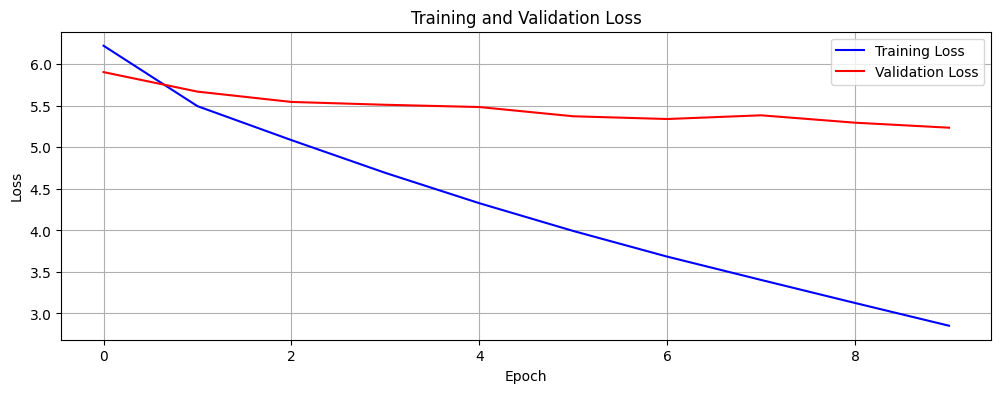

Final training loss: 2.8521
Final validation loss: 5.2372


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Validation accuracy: 0.2941 (29.41%)


In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 4))

# Plot on the first subplot
plt.plot(train_losses, 'b-', label='Training Loss')
plt.plot(val_losses, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

print(f"Final training loss: {train_losses[-1]:.4f}")
print(f"Final validation loss: {val_losses[-1]:.4f}")

# Calculate accuracy on validation set
def calculate_accuracy(model, data_loader, vocab):
    model.eval()
    correct_tokens = 0
    total_tokens = 0

    with torch.no_grad():
        for batch in data_loader:
            src = batch['src'].to(device)
            tgt = batch['tgt'].to(device)

            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]

            output = model(src, tgt_input)
            predictions = output.argmax(dim=-1)

            # Only count non-padding tokens
            mask = (tgt_output != 0)
            correct_tokens += ((predictions == tgt_output) & mask).sum().item()
            total_tokens += mask.sum().item()

    return correct_tokens / total_tokens if total_tokens > 0 else 0

val_accuracy = calculate_accuracy(model, val_loader, french_vocab)
print(f"Validation accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")

**The Story in Numbers**:
- Training loss: 6.22 → 2.85 (excellent - the model is learning!)
- Validation loss: 5.91 → 5.24 (concerning - barely improved)

**What this tells us**: Classic overfitting! The model memorized the training data but didn't generalize. This is mathematically inevitable with only 1000 examples - production systems need millions.

## Inference and Translation

The real test: can our transformer translate sentences it has never seen? This is where we implement autoregressive generation - the same process ChatGPT uses to generate text.

### Autoregressive Generation: One Token at a Time

Unlike training (where we see the entire target sequence), inference generates token-by-token:

```
Input: "Hello world"
Step 1: <sos> → "bonjour" (probability distribution over 1790 French words)
Step 2: <sos> bonjour → "le" 
Step 3: <sos> bonjour le → "monde"
Step 4: <sos> bonjour le monde → <eos> (stop)
Output: "bonjour le monde"
```

**Mathematical process**: At each step, the model computes P(next_word | input, previous_words) and selects the highest probability token (greedy decoding).


Our `translate_sentence()` function implements this exactly:
1. **Encode**: Convert English to token indices
2. **Initialize**: Start with `<sos>` token  
3. **Generate**: Predict next token given current sequence
4. **Repeat**: Until `<eos>` or max length reached
5. **Decode**: Convert token indices back to French text

### Expected Results vs Reality

**What good translations look like**:
- "Hello" → "Bonjour" (direct mapping)
- "Thank you" → "Merci" (common phrase)
- "Good morning" → "Bonjour" (contextual understanding)


In [ ]:
def translate_sentence(model, sentence, src_vocab, tgt_vocab, max_length=50):
    """
    Translate a single sentence using the trained model
    """
    model.eval()

    # Convert input sentence to indices
    src_indices = src_vocab.sentence_to_indices(sentence, add_eos=True)
    src_tensor = torch.tensor([src_indices], dtype=torch.long).to(device)

    # Initialize target with SOS token
    tgt_indices = [tgt_vocab.word2idx["<sos>"]]

    with torch.no_grad():
        for _ in range(max_length):
            tgt_tensor = torch.tensor([tgt_indices], dtype=torch.long).to(device)

            # Get model prediction
            output = model(src_tensor, tgt_tensor)

            # Get the prediction for the last token
            next_token_logits = output[0, -1, :]
            next_token = next_token_logits.argmax().item()

            # Add predicted token to target sequence
            tgt_indices.append(next_token)

            # Stop if we predict EOS token
            if next_token == tgt_vocab.word2idx["<eos>"]:
                break

    # Convert indices back to sentence
    translated_sentence = tgt_vocab.indices_to_sentence(tgt_indices)
    return translated_sentence

# Test on validation examples
for i, (en_sentence, de_sentence) in enumerate(val_pairs[:5]):
    translation = translate_sentence(model, en_sentence, english_vocab, french_vocab)
    print(f"Example {i+1}:")
    print(f"English: '{en_sentence}'")
    print(f"Expected: '{de_sentence}'")
    print(f"Generated: '{translation}'")
    print("-" * 30)

Example 1:
English: 'Arabic is read from right to left.'
Expected: 'L'arabe se lit de droite à gauche.'
Generated: 'il est à ma ?'
------------------------------
Example 2:
English: 'Compared with yours, my car is small.'
Expected: 'Comparée à ta voiture, la mienne est petite.'
Generated: 'c'est une est un bon en train de mon soleil.'
------------------------------
Example 3:
English: 'That'll be enough.'
Expected: 'Ça sera suffisant.'
Generated: 'nous devons à tom ?'
------------------------------
Example 4:
English: 'Tom likes to climb the trees.'
Expected: 'Tom aime grimper aux arbres.'
Generated: 'tom a été en train de tom ?'
------------------------------
Example 5:
English: 'I just took a shower.'
Expected: 'Je viens de prendre une douche.'
Generated: 'je n'ai pas à une telle d'un'
------------------------------


## Summary

Congratulations! You've built a complete transformer translation pipeline from scratch. More importantly, you've learned why transformers work - and why they sometimes don't.